# Optimización Bayesiana

En este notebook se muestra la obtención de hiperparámetros óptimos para una red neuronal utilizando optimización bayesiana. Esta técnica es más eficiente que un Gridsearch o Manual tuning para casos (como el actual) en el que no se tienen recursos para realizar entrenamientos en paralelo de modelos.


https://arxiv.org/pdf/1807.02811.pdf

**NOTA:** Este notebook está ejecutado en *Google Colab*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade pandas
!pip install --upgrade matplotlib==2.1.1
!pip install scikit-optimize

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
     |████████████████████████████████| 15.0MB 3.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


     |████████████████████████████████| 81kB 3.6MB/s 


In [3]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_getting_real.pickle
GoogleNews-vectors-negative300.bin.gz  news_proc_12_3_19.pickle


# Imports, loads and Train/test split
---

In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels asignadas a los tipos

In [6]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


In [7]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1598
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [0]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [0]:
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed
from tensorflow import set_random_seed

import tensorflow as tf

import os

# Buscar hiperparámetros óptimos para la CNN

In [0]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.4, name='momentum'),
          Real(1e-3, 0.4, name='dropout1'),
          Real(1e-3, 0.4, name='dropout2'),
          Integer(5,15, name='filters1Title'),
          Integer(25,60, name='denseTitle'),
          Integer(5,15, name='filtersContent'),
          Integer(25,60, name='denseContent') ]

In [0]:
@use_named_args(space)
def cnn_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible
    seed(50)
    set_random_seed(50)
    k.backend.clear_session()
    
    
    
    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = params['filters1Title'], kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(params['denseTitle'], activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = params['filtersContent'], kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)
    
    x2 = k.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(params['denseContent'], activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(params['dropout2'])(x)
    out = k.layers.Dense(4, activation='softmax')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(lr=params['lr'], momentum=params['momentum']), loss='categorical_crossentropy', metrics=['acc'])
    
    out = model.fit(x=x_train, y=y_train2, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                    validation_data=(x_valid, y_valid2))
    
    
    #Evaluation
    
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [15]:
r = skopt.gp_minimize(cnn_model, n_random_starts=3, n_calls=5, dimensions=space)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 94319 samples, validate on 40423 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
94319/94319 [==============================] - 24s 257us/sample - loss: 0.8946 - acc: 0.6886 - val_loss: 0.6608 - val_acc: 0.7809
Epoch 2/20
94319/94319 [==============================] - 20s 217us/sample - loss: 0.6655 - acc: 0.7894 - val_loss: 0.6356 - val_acc: 0.8023
Epoch 3/20
57747/57747 [==============================] - 8s 147us/sample - loss: 0.6604 - acc: 0.8098
Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 22s 233us/sample - loss: 0.9276 - acc: 0.6790 - val_loss: 0.6373 - val_acc: 0.7870
Epoch 2/20
94319/94319 [==============================] - 21s 226us/sample - loss: 0.6315 - acc: 0.7949 - val_loss: 0.6188 - val_acc: 0.801

Podemos aceder a los parámetros con los que se obtiene el mínimo en la función de loss (máximo en nuestro caso)

In [16]:
print("PARAMETERS: {}  RESULT {}".format(r.x, r.fun))

PARAMETERS: [0.23993334664040306, 0.30361299021107185, 0.10993063833594595, 0.1586041045258562, 8, 42, 6, 34]  RESULT -0.8202331066131592


Como vemos, con estos parámetros se obtiene un accuracy de 0.81 en el conjunto de validación.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbad0999e10>,
      dtype=object)

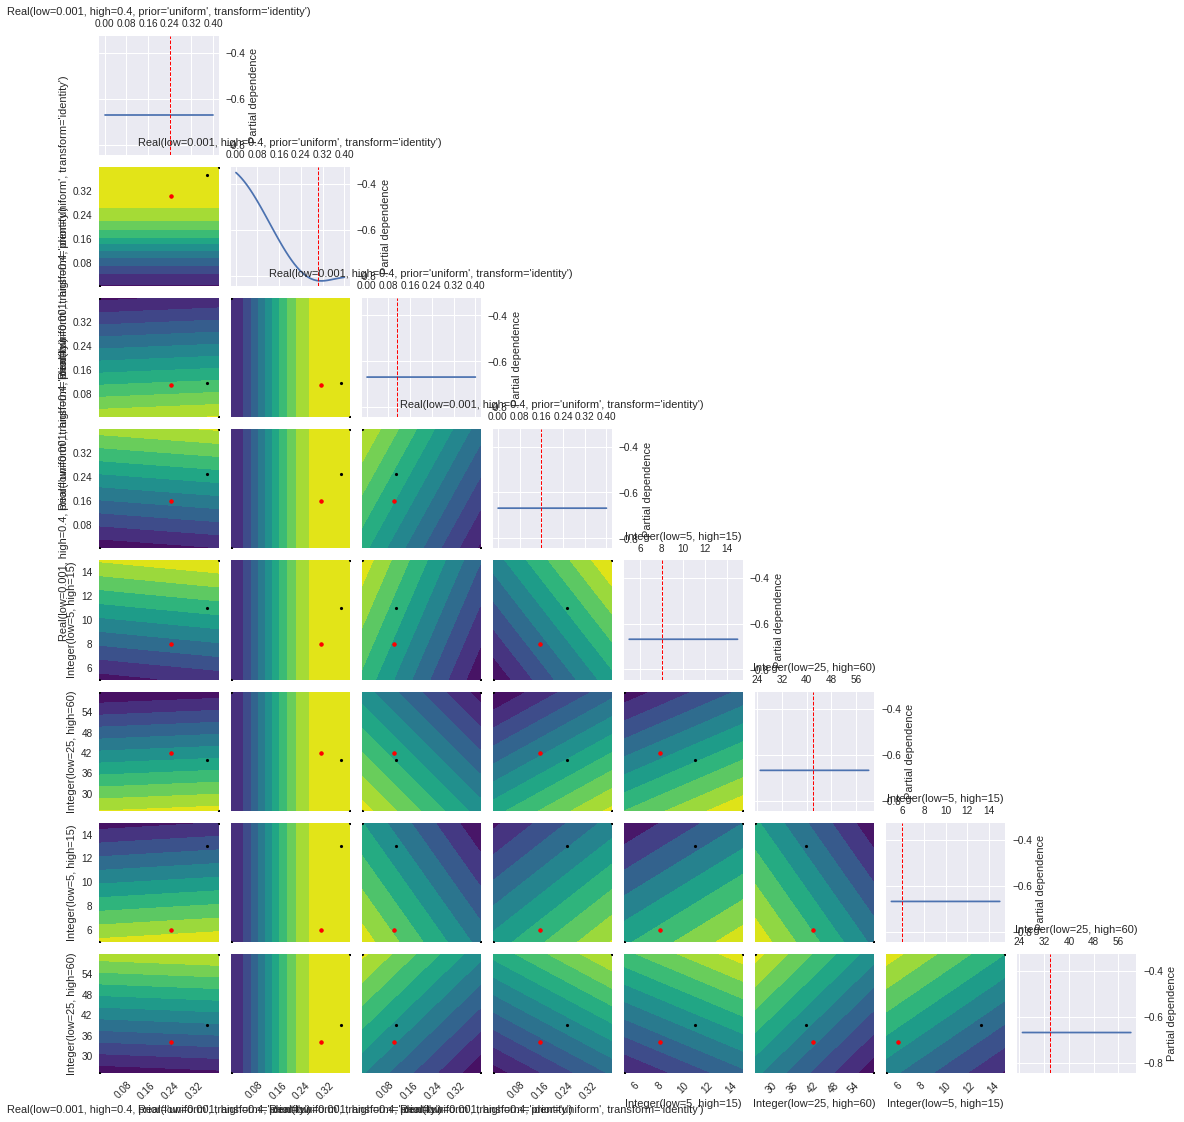

In [17]:
plot_objective(r, dimensions=space)

In [18]:
print("Params")
r.x_iters

Params


[[0.3609023142323129,
  0.3722126565768866,
  0.11730623905087469,
  0.25052331238968567,
  11,
  40,
  13,
  39],
 [0.23993334664040306,
  0.30361299021107185,
  0.10993063833594595,
  0.1586041045258562,
  8,
  42,
  6,
  34],
 [0.23993334664040306,
  0.30361299021107185,
  0.10993063833594595,
  0.1586041045258562,
  8,
  42,
  6,
  34],
 [0.001, 0.001, 0.4, 0.001, 5, 60, 5, 25],
 [0.4, 0.4, 0.001, 0.4, 15, 25, 15, 60]]

In [19]:
print("Values")
r.func_vals

Values


array([-0.80979097, -0.8195751 , -0.8202331 , -0.34843367, -0.80527127],
      dtype=float32)

# Buscar hiperparámetros óptimos para la LSTM

In [0]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.1, name='momentum'),
          Real(0.1, 0.3, name='dropout1'),
          Integer(50,100, name='dense1'),
          Integer(20,50, name='dense2'),
          Integer(20,100, name='lstmTitle'),
          Integer(50,300, name='lstmContent')]


@use_named_args(space)
def lstm_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible weights
    seed(50)
    set_random_seed(50)
    k.backend.clear_session()
    
    
    

    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False)(title_input)
    x = k.layers.Bidirectional(k.layers.LSTM(params['lstmTitle']))(inp)
    #CudnnLSTM

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False)(content_input)
    x2 = k.layers.Bidirectional(k.layers.LSTM(params['lstmContent']))(inp2)
    #CudnnLSTM

    #Merge
    x = k.layers.concatenate([x, x2])


    #Common part
    x = k.layers.Dense(params['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(params['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    out = k.layers.Dense(4, activation='softmax')(x)

    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    #model.compile(k.optimizers.SGD(), loss='categorical_crossentropy', metrics=['acc'])
    model.compile(tf.train.MomentumOptimizer(learning_rate=params['lr'], momentum=params['momentum']), 
                  loss='categorical_crossentropy', metrics=['acc'])

    
    
    
    
    #Optimize TPU
    # This address identifies the TPU we'll use when configuring TensorFlow.
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tf.logging.set_verbosity(tf.logging.INFO)

    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))



    
    out = tpu_model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64*8, epochs=30,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                         validation_data=(valid_fit, np.array(y_valid.tolist())))
    

    
    
    #Evaluation
    acc = tpu_model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [16]:
r = skopt.gp_minimize(lstm_model, n_random_starts=3, n_calls=5, dimensions=space)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.120.214.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10182065026619425116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 624929692778327347)
INFO:tensorflow:*** Available Device: _DeviceAt

In [17]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.2639850638741692, 0.08255873365806747, 0.10591561319817788, 73, 24, 46, 231]  RESULT -0.7371156215667725


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5902fe8128>,
      dtype=object)

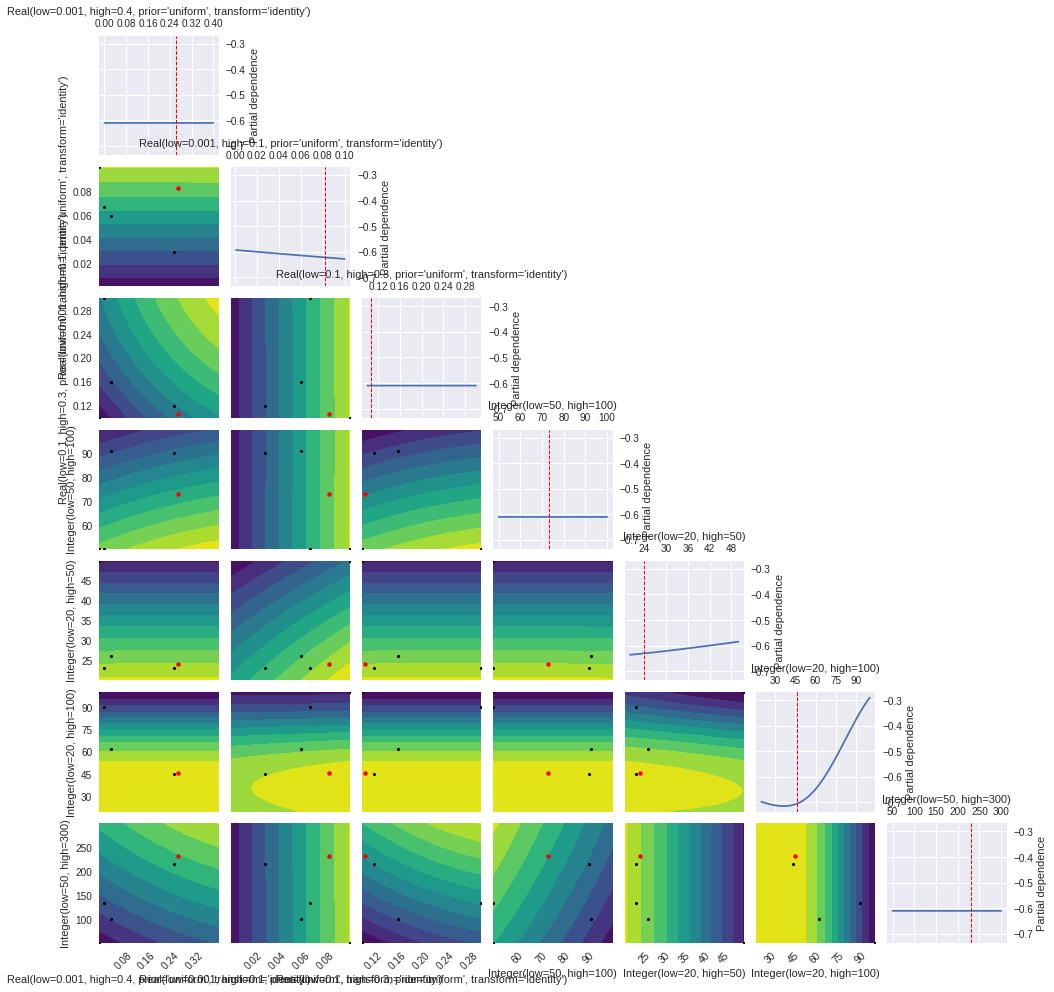

In [18]:
plot_objective(r, dimensions=space)